In [4]:
%idle_timeout 5
%worker_type Standard
%number_of_workers 2

Welcome to the Glue Interactive Sessions Kernel
For more information on available magic commands, please type %help in any new cell.

Please view our Getting Started page to access the most up-to-date information on the Interactive Sessions kernel: https://docs.aws.amazon.com/glue/latest/dg/interactive-sessions.html
Installed kernel version: 1.0.6 
Current idle_timeout is None minutes.
idle_timeout has been set to 5 minutes.
Previous worker type: None
Setting new worker type to: Standard
Previous number of workers: None
Setting new number of workers to: 2


In [26]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("muted")
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, VectorAssembler
import re
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col

In [2]:
spark = SparkSession.builder.appName("Amazon Product Data Exploration").getOrCreate()

# 1. Load Data

In [3]:
input_path = "s3://amazon-product-dataset-2024/cleaned/"

In [4]:
df = spark.read.parquet(input_path)

In [5]:
df.show()

+----------+--------------------+-----+-------+------------------+---------+-----------+------------+-----------------+-------------+
|      asin|               title|stars|reviews|             price|listPrice|category_id|isBestSeller|boughtInLastMonth|has_listPrice|
+----------+--------------------+-----+-------+------------------+---------+-----------+------------+-----------------+-------------+
|B09VX44LMP|Sweet Messenger T...|  4.7|     12|              62.0|      0.0|        118|       False|                0|        False|
|B0BS759SV5|Dori Crossbody, V...|  4.5|      0|             178.0|      0.0|        118|       False|                0|        False|
|B0B2PQVQF4|Theater Tote Bag ...|  4.5|      4|15.890000343322754|      0.0|        118|       False|                0|        False|
|B09J4D7GFX|Women Evening Han...|  4.6|    342|25.989999771118164|      0.0|        118|       False|                0|        False|
|B07DQX64XB|Vintage 1930 Upcy...|  4.7|    178|26.219999313354

In [6]:
df.describe().show()

+-------+--------------------+--------------------+-------------------+------------------+--------------------+------------------+------------------+------------+------------------+-------------+
|summary|                asin|               title|              stars|           reviews|               price|         listPrice|       category_id|isBestSeller| boughtInLastMonth|has_listPrice|
+-------+--------------------+--------------------+-------------------+------------------+--------------------+------------------+------------------+------------+------------------+-------------+
|  count|             1372587|             1372587|            1372587|           1372587|             1372587|           1372587|           1372587|     1372587|           1372587|      1372587|
|   mean|1.8160756785002997E9|3.846153846153846...|  4.378717478596322|183.20376850429153|  42.848201525974645|12.273176126736459|123.76410894172828|        null|143.43152747330407|         null|
| stddev|1.864481623

In [13]:
products_pd = df.toPandas()

In [6]:
bucket_name = 'amazon-product-dataset-2024'
categories_file_path = 's3://{}/amazon_categories.csv'.format(bucket_name)
categories_df = spark.read.csv(categories_file_path, header=True, inferSchema=True)
categories_df.show(5)

+---+--------------------+
| id|       category_name|
+---+--------------------+
|  1|Beading & Jewelry...|
|  2|   Fabric Decorating|
|  3|Knitting & Croche...|
|  4|Printmaking Supplies|
|  5|Scrapbooking & St...|
+---+--------------------+
only showing top 5 rows


In [9]:
categories_pd = categories_df.toPandas()

# 2. Univariate Distribution

### **`isBestSeller`**

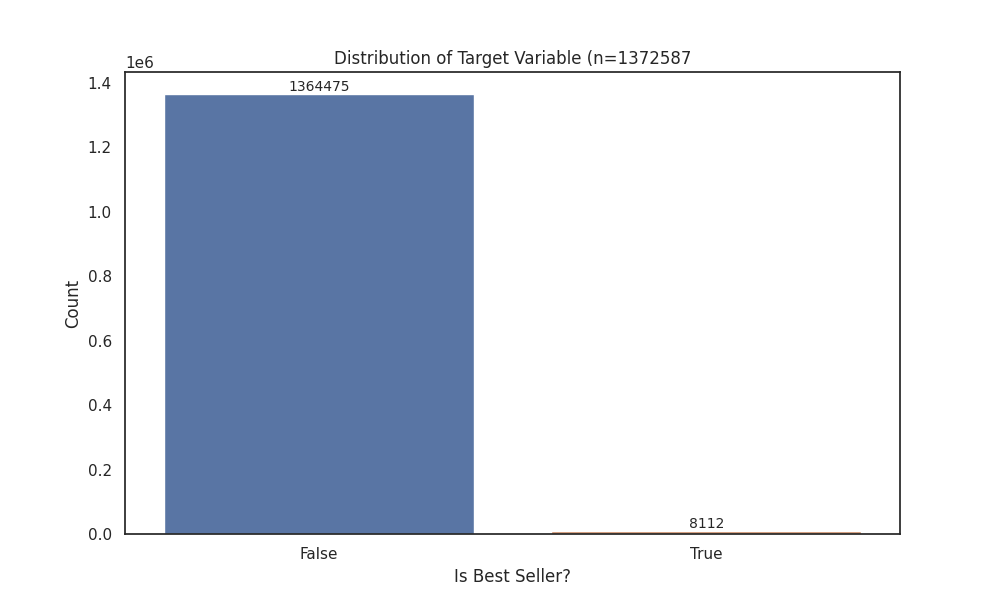

In [11]:
sns.set(style="white")
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='isBestSeller', data=products_pd)
plt.title('Distribution of Target Variable (n = 1372587)')
plt.xlabel('Is Best Seller?')
plt.ylabel('Count')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)
plt.show();
%matplot plt

### **`stars`**

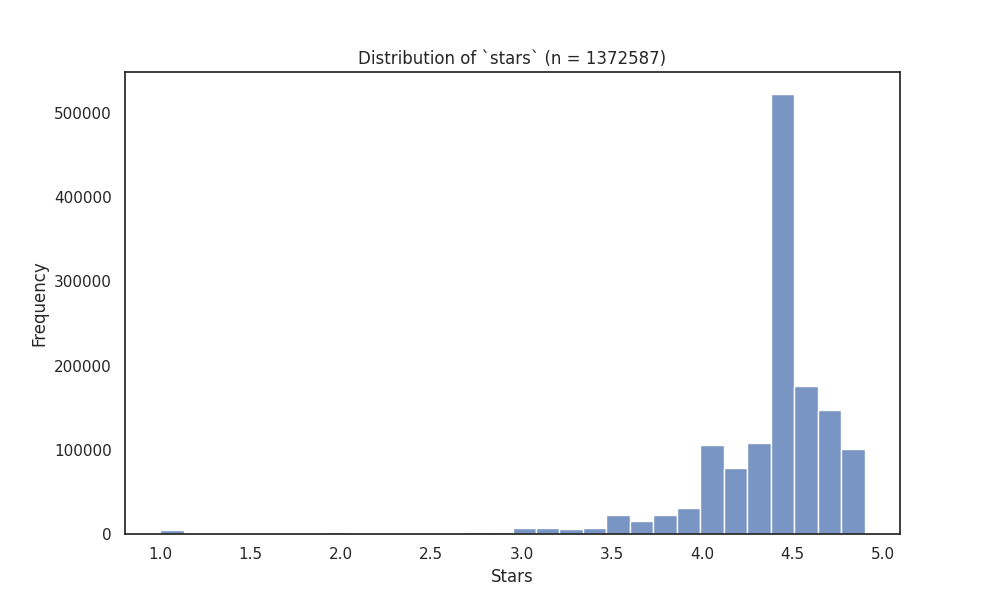

In [12]:
sns.set(style="white")
plt.figure(figsize=(10, 6))
sns.histplot(products_pd['stars'], bins=30)
plt.title('Distribution of `stars` (n = 1372587)')
plt.xlabel('Stars')
plt.ylabel('Frequency')
plt.show();
%matplot plt

### **`reviews`**

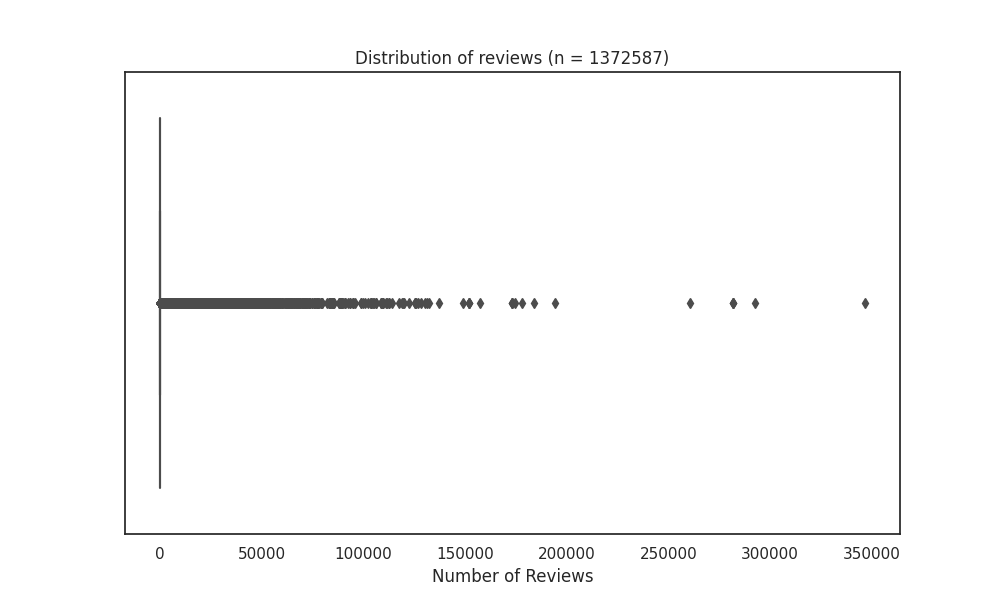

In [19]:
sns.set(style="white")
plt.figure(figsize=(10, 6))
sns.boxplot(x=products_pd['reviews'])
plt.title('Distribution of reviews (n = 1372587)')
plt.xlabel('Number of Reviews')
plt.show();
%matplot plt

### **`price`**

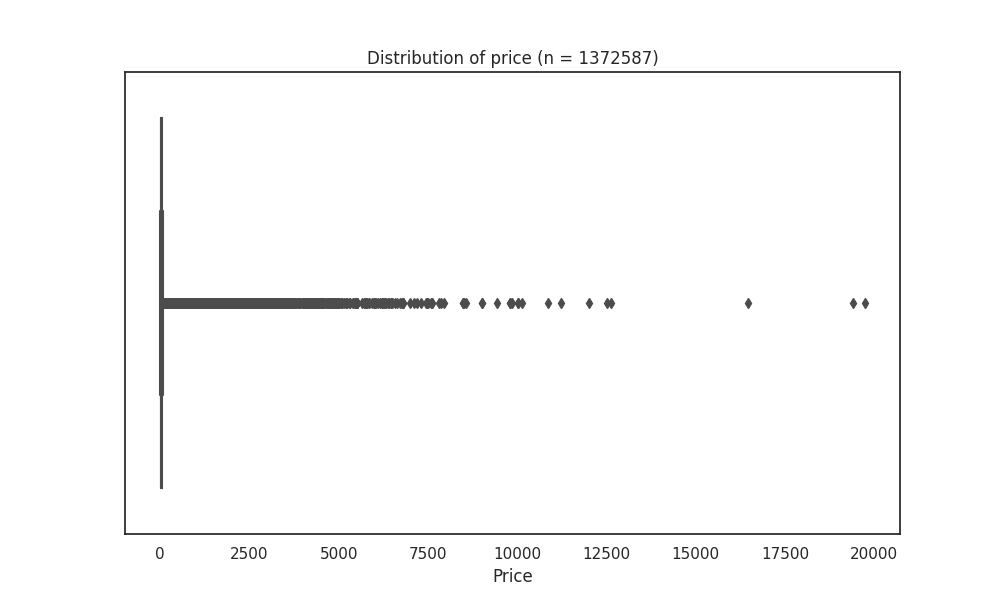

In [18]:
sns.set(style="white")
plt.figure(figsize=(10, 6))
sns.boxplot(x=products_pd['price'])
plt.title('Distribution of price (n = 1372587)')
plt.xlabel('Price')
plt.show();
%matplot plt

### **`listPrice`**

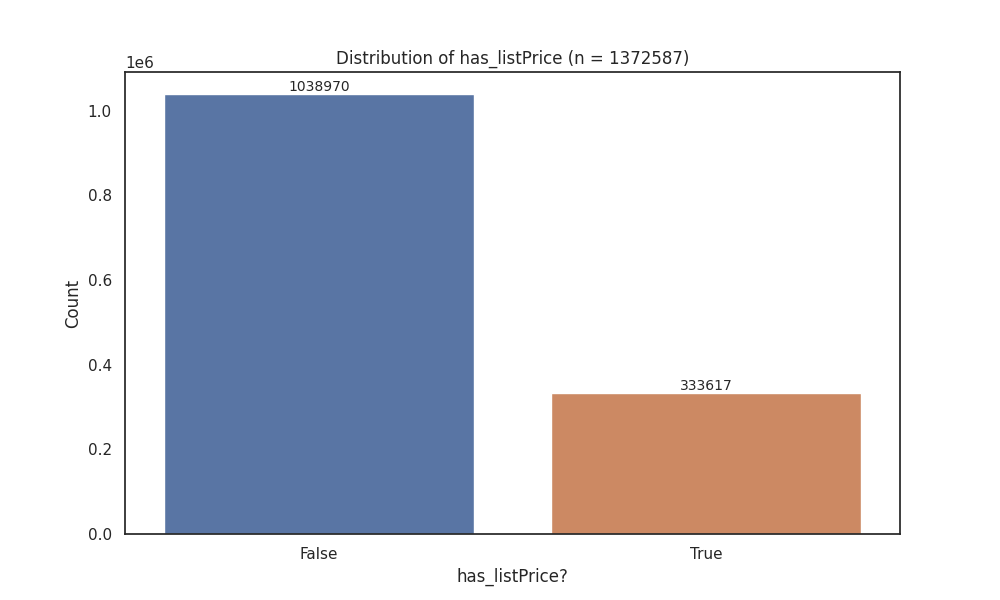

In [15]:
sns.set(style="white")
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='has_listPrice', data=products_pd)
plt.title('Distribution of has_listPrice (n = 1372587)')
plt.xlabel('has_listPrice?')
plt.ylabel('Count')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)
plt.show();
%matplot plt

### **`boughtInLastMonth`**

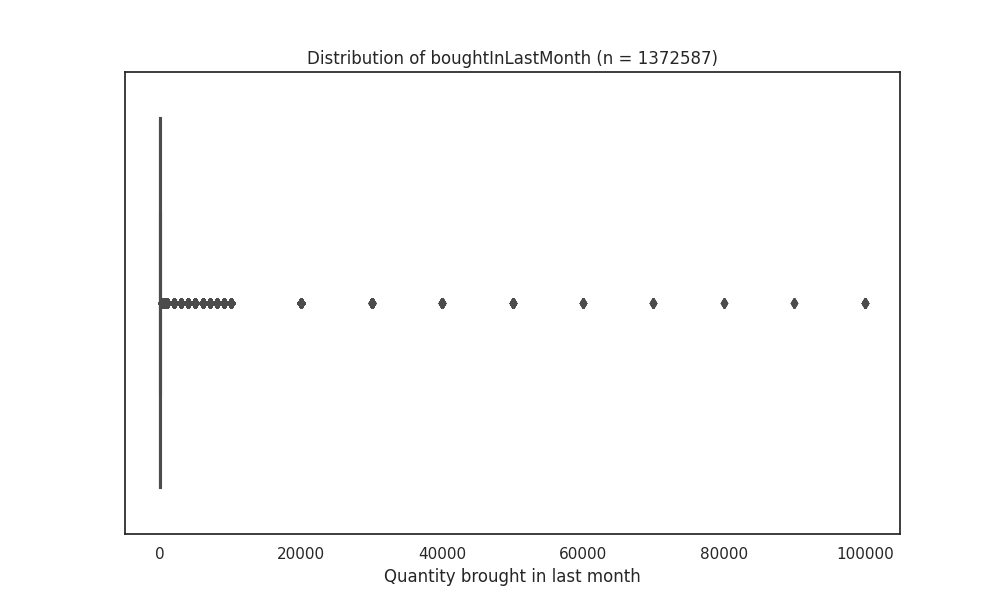

In [20]:
sns.set(style="white")
plt.figure(figsize=(10, 6))
sns.boxplot(x=products_pd['boughtInLastMonth'])
plt.title('Distribution of boughtInLastMonth (n = 1372587)')
plt.xlabel('Quantity brought in last month')
plt.show();
%matplot plt

## Decision on 'title' Feature

For our initial classification model predicting 'isBestSeller':

- We've decided to exclude the 'title' feature due to its unstructured nature and potential for introducing noise.
- Rationale:
  1. Reduces risk of overfitting to specific, possibly irrelevant, words in titles.
  2. Simplifies the model and reduces computational complexity.
  3. Avoids potential issues with "weird values" that might affect model performance.

Future considerations:
- If initial model performance is unsatisfactory, we may revisit 'title' with careful preprocessing:
  * Text cleaning and normalization
  * Feature extraction (e.g., title length, word count, keyword presence)
  * Advanced NLP techniques (TF-IDF, word embeddings)
- Any inclusion of 'title'-derived features will be accompanied by comparative analysis to justify their addition.

Remember: Sometimes, simpler models with cleaner, more structured data perform better. We can always add complexity if needed.

# 3. Relationship Analysis

#### a) Correlation Analysis

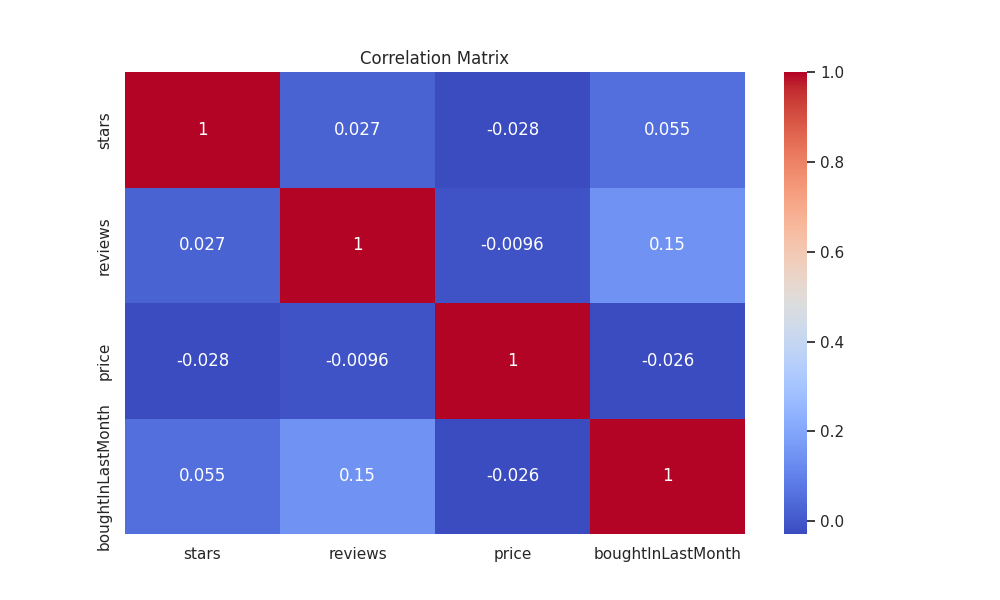

In [32]:
correlation_mat = products_pd[['stars', 'reviews', 'price', 'boughtInLastMonth']].corr()
plt.clf()
sns.heatmap(correlation_mat, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show();
%matplot plt

#### b) Pairplot of Numeric Variables

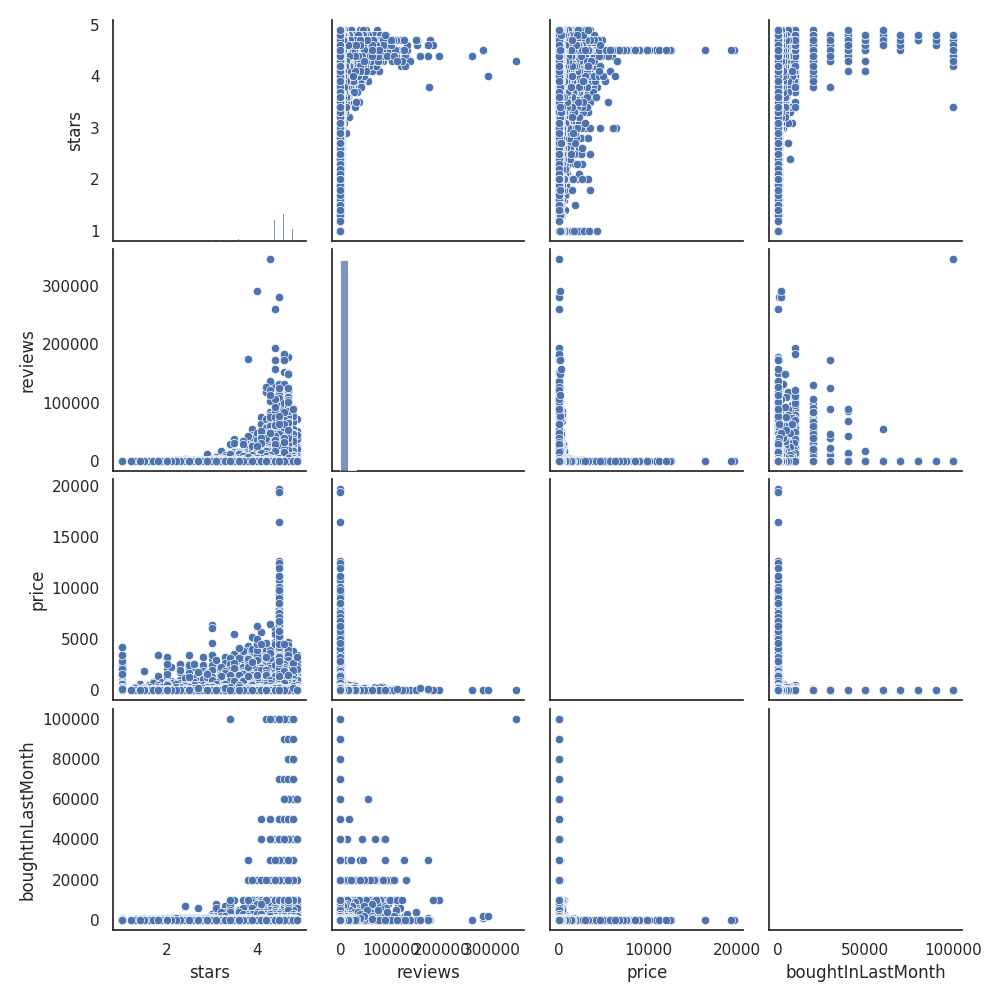

In [34]:
sns.pairplot(products_pd[['stars', 'reviews', 'price', 'boughtInLastMonth']])
plt.show();
%matplot plt

#### c) Number of Products in each Category of Best Sellers

In [7]:
# Create temp views
df.createOrReplaceTempView("products_temp")
categories_df.createOrReplaceTempView("categories_temp")

In [8]:
check_count_query = """
SELECT c.category_name, COUNT(p.asin) AS product_count
FROM categories_temp c
LEFT JOIN products_temp p ON c.id = p.category_id
GROUP BY c.category_name
ORDER BY product_count DESC;
"""

In [9]:
category_counts_df = spark.sql(check_count_query)
category_counts_df.show()

+--------------------+-------------+
|       category_name|product_count|
+--------------------+-------------+
|     Girls' Clothing|        28613|
|      Boys' Clothing|        24646|
|        Toys & Games|        20531|
|         Men's Shoes|        19657|
|    Women's Handbags|        18968|
|      Girls' Jewelry|        18431|
|      Men's Clothing|        18215|
|   Men's Accessories|        17573|
|    Women's Clothing|        17371|
|     Women's Jewelry|        16882|
|  Travel Accessories|        16085|
|       Women's Shoes|        15605|
|Home Storage & Or...|        14644|
| Women's Accessories|        13868|
|       Men's Watches|        12817|
|        Girls' Shoes|        10935|
|       Boys' Jewelry|        10800|
|Foot, Hand & Nail...|         9481|
|           Backpacks|         9383|
|  Office Electronics|         9249|
+--------------------+-------------+
only showing top 20 rows


In [10]:
category_product_counts_pdf = category_counts_df.toPandas()

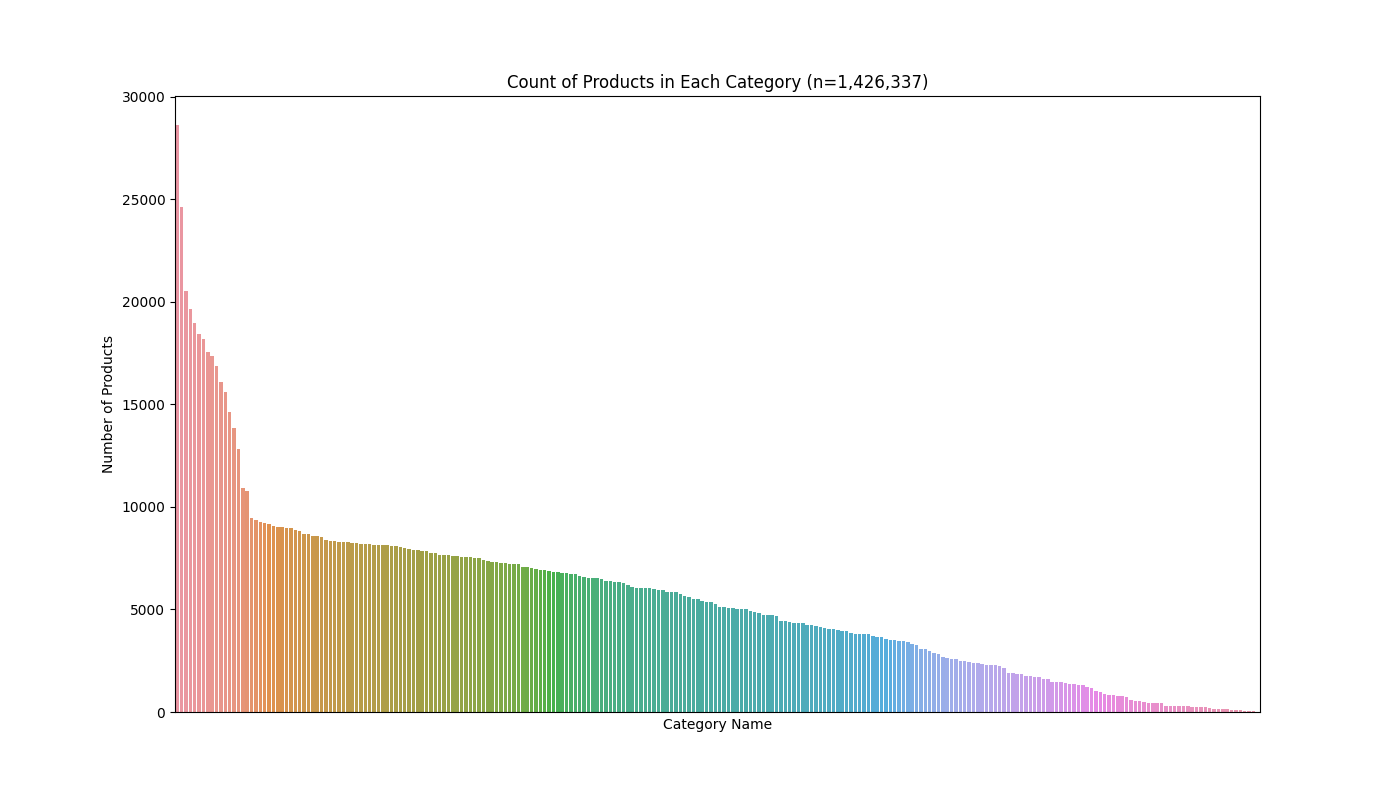

In [11]:
# Plot count of products in each category
%matplotlib inline

sns.set_palette("Spectral")
plt.figure(figsize=(14, 8))
sns.barplot(x='category_name', y='product_count', data=category_product_counts_pdf)
plt.title("Count of Products in Each Category (n=1,426,337)")
plt.xlabel('Category Name')
plt.ylabel('Number of Products')
plt.xticks(rotation=45)
plt.xticks([])
plt.show();
%matplot plt

#### d) Boxplot of numeric variables for each label (target variable: isBestSeller)

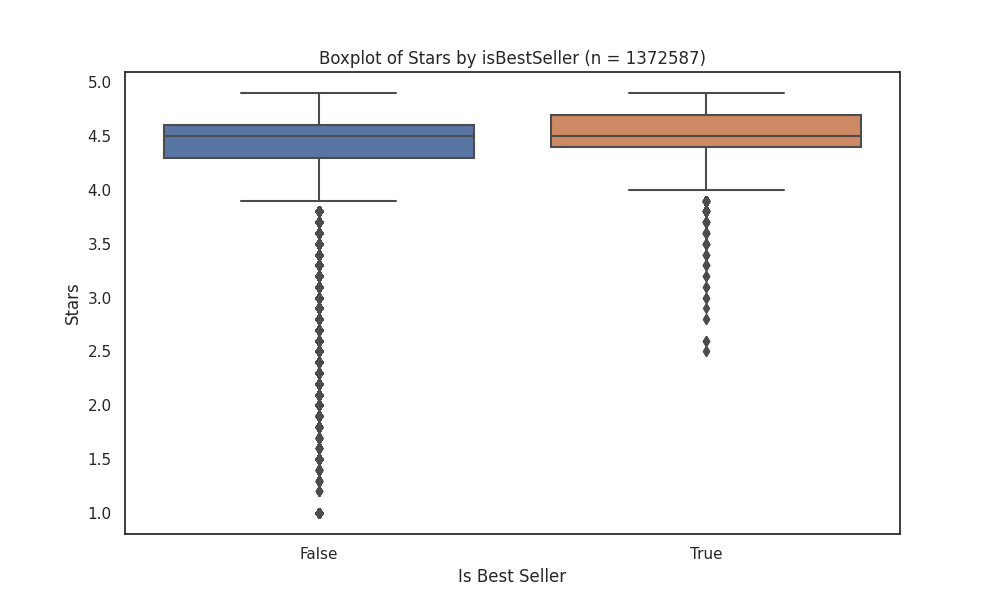

In [14]:
sns.set(style="white")
plt.figure(figsize=(10, 6))
sns.boxplot(data=products_pd, x='isBestSeller', y='stars')
plt.title('Boxplot of Stars by isBestSeller (n = 1372587)')
plt.xlabel('Is Best Seller')
plt.ylabel('Stars')
plt.show();
%matplot plt

#### e) Identify tokens in `title` with highest correlation with best sellers

- Tokenize the product title into individual words (tokens).
- Identify frequent words (keywords) in the product titles.
- One-Hot Encode or Count the Occurrences of these keywords in the title.
- Calculate correlation or feature importance between these keywords and the isBestSeller column.

In [15]:
# Tokenize the product title into individual words
tokenizer = Tokenizer(inputCol="title", outputCol="title_tokens")
df = tokenizer.transform(df)

# Show the tokenized titles
df.select("title", "title_tokens").show()

+--------------------+--------------------+
|               title|        title_tokens|
+--------------------+--------------------+
|Sweet Messenger T...|[sweet, messenger...|
|Dori Crossbody, V...|[dori, crossbody,...|
|Theater Tote Bag ...|[theater, tote, b...|
|Women Evening Han...|[women, evening, ...|
|Vintage 1930 Upcy...|[vintage, 1930, u...|
|14 Inch Leather C...|[14, inch, leathe...|
|Western Leather T...|[western, leather...|
|Twiggy Crossbody Bag|[twiggy, crossbod...|
|Signature Crossbo...|[signature, cross...|
|Women's Hand Wris...|[women's, hand, w...|
|Purses and Handba...|[purses, and, han...|
|Credit Card Prote...|[credit, card, pr...|
|Mini Heart Round ...|[mini, heart, rou...|
|Sillage Shoulder ...|[sillage, shoulde...|
|Wave Shape Clutch...|[wave, shape, clu...|
|Gremlins Gizmo Ho...|[gremlins, gizmo,...|
|PU Leather Small ...|[pu, leather, sma...|
|Women's Drawstrin...|[women's, drawstr...|
|Punk Gothic Skull...|[punk, gothic, sk...|
|Women's JADEZ Dom...|[women's, 

In [28]:
# Remove stopwords
default_stopwords = StopWordsRemover.loadDefaultStopWords("english")
custom_stopwords = default_stopwords + ['&', '|', '-', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0']  # Add symbols and numbers

# Create a custom StopWordsRemover with the updated list
remover = StopWordsRemover(inputCol="title_tokens", outputCol="filtered_tokens2", stopWords=custom_stopwords)
df = remover.transform(df)

# Show the filtered tokens
df.select("title", "filtered_tokens").show(truncate=False)


+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|title                                                                                                                                                                     |filtered_tokens                                                                                                                                                                                      |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------

In [31]:
# Fit a CountVectorizer model to extract word counts
cv = CountVectorizer(inputCol="filtered_tokens2", outputCol="title_features3", vocabSize=100, minDF=5)
cv_model = cv.fit(df)
df = cv_model.transform(df)

# Show the top 50 most frequent words (keywords)
vocab = cv_model.vocabulary
print("Top 50 Keywords: ", vocab)

Top 50 Keywords:  ['kids', 'pack', 'baby', 'set', 'x', 'women', 'girls', 'black', 'bag', 'inch', 'party', 'compatible', 'gift', 'car', 'replacement', 'light', 'kit', 'boys', 'toys', 'led', 'birthday', 'white', 'steel', 'pcs', 'wall', 'travel', 'gifts', 'case', 'storage', 'toy', 'usb', 'men', 'cover', 'water', 'home', 'mini', 'small', 'waterproof', 'adjustable', 'large', 'soft', 'toddler', 'accessories', 'halloween', "men's", 'holder', 'stainless', 'watch', 'long', 'air', 'jewelry', '12', 'plastic', 'hair', 'diy', 'outdoor', 'bags', '10', 'portable', 'leather', "women's", 'tool', 'metal', 'high', 'cable', 'box', 'pro', 'gold', 'decor', 'sleeve', 'door', 'power', 'size', '–', 'shower', 'christmas', 'earrings', 'wireless', 'art', 'clear', 'silver', 'blue', 'silicone', 'cat', 'series', 'cotton', 'pieces', 'game', 'decorations', 'organizer', 'dress', 'cute', 'heavy', 'color', 'lights', 'supplies', 'glass', 'filter', 'nail', 'wedding']


In [32]:
vocab = cv_model.vocabulary[:50]  # Top 50 words

# Extract the counts for each word
# Summing across the rows for the title_features3 column to get the total word counts
word_counts = df.select("title_features3").rdd \
    .map(lambda row: row.title_features3.toArray()) \
    .reduce(lambda x, y: x + y)  # Sum the arrays to get total counts per word

# Filter for top 50 words
top_word_counts = word_counts[:50]


In [33]:
# Create a Pandas DataFrame with word and frequency
data = pd.DataFrame(list(zip(vocab, top_word_counts)), columns=['Word', 'Count'])
data = data.sort_values(by="Count", ascending=False)

# Display the top 10 words as a check
print(data.head(10))


    Word     Count
0   kids  101304.0
1   pack   92458.0
2   baby   92423.0
3    set   89784.0
4      x   86778.0
5  women   86716.0
6  girls   84534.0
7  black   80191.0
8    bag   77928.0
9   inch   74288.0


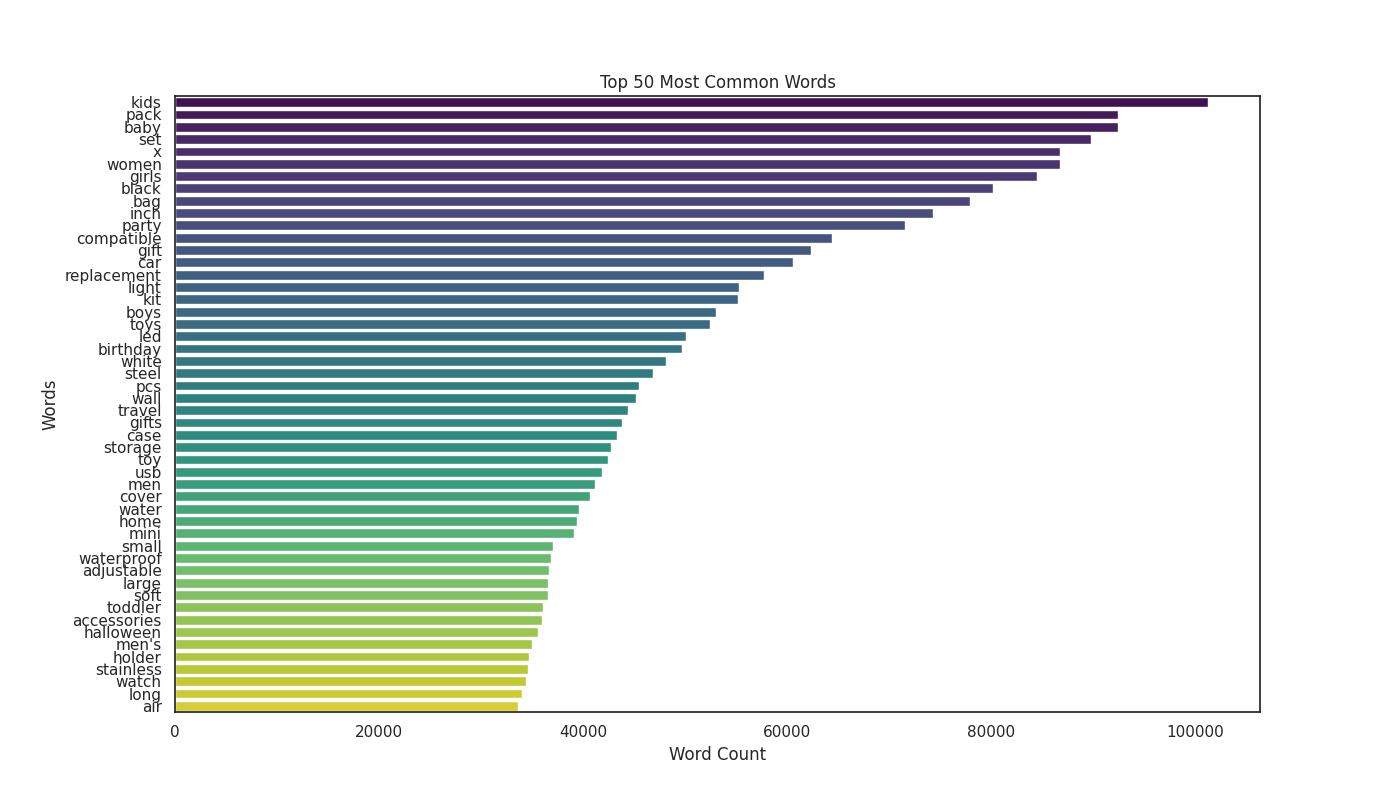

In [35]:
# Plot the top 50 words
sns.set_palette("Spectral")
plt.figure(figsize=(14, 8))
sns.barplot(x="Count", y="Word", data=data, palette="viridis")
plt.title("Top 50 Most Common Words")
plt.xlabel("Word Count")
plt.ylabel("Words")
plt.show();
%matplot plt